In [1]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [2]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [3]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [5]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [6]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [7]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [8]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [9]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [10]:
print(training_data_Y[0].shape)

(200,)


In [11]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [12]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [13]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [14]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [15]:
import torch.utils.data

In [16]:
# Dataset Hyper Parameters
num_epochs = 20
batch_size = 100

In [17]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [68]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.5,
                final_hidden_layer_sizes = [],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([8, 1, 1, 10])
torch.Size([8])
torch.Size([8, 8, 1, 10])
torch.Size([8])
torch.Size([8, 8, 22, 1])
torch.Size([8])
torch.Size([32, 8])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


torch.Size([1775, 4])


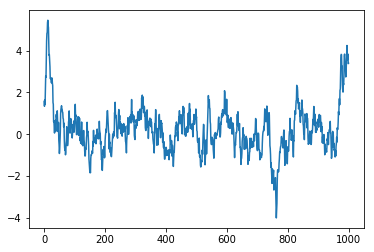

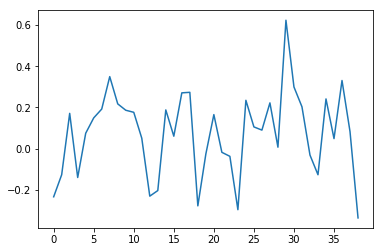

torch.Size([1775, 4])
torch.Size([1775, 64])


In [62]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)

net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
    
print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [1/17] Loss: [----- 2.9642 = 1.4763 + 100.00 * 0.0000 + 0.05 * 29.7591 -----]
Epoch [1/20], Iter [2/17] Loss: [----- 2.9497 = 1.4484 + 100.00 * 0.0001 + 0.05 * 29.7562 -----]
Epoch [1/20], Iter [3/17] Loss: [----- 3.0190 = 1.4366 + 100.00 * 0.0009 + 0.05 * 29.7539 -----]
Epoch [1/20], Iter [4/17] Loss: [----- 2.9625 = 1.4746 + 100.00 * 0.0000 + 0.05 * 29.7520 -----]
Epoch [1/20], Iter [5/17] Loss: [----- 2.9316 = 1.4315 + 100.00 * 0.0001 + 0.05 * 29.7498 -----]
Epoch [1/20], Iter [6/17] Loss: [----- 2.9978 = 1.4318 + 100.00 * 0.0008 + 0.05 * 29.7477 -----]
Epoch [1/20], Iter [7/17] Loss: [----- 2.9735 = 1.4836 + 100.00 * 0.0000 + 0.05 * 29.7458 -----]
Epoch [1/20], Iter [8/17] Loss: [----- 3.1976 = 1.4302 + 100.00 * 0.0028 + 0.05 * 29.7438 -----]
Epoch [1/20], Iter [9/17] Loss: [----- 3.4997 = 1.4232 + 100.00 * 0.0059 + 0.05 * 29.7418 -----]
Epoch [1/20], Iter [10/17] Loss: [----- 3.7733 = 1.4796 + 100.00 * 0.0081 + 0.05 * 29.7400 -----]
Epoch [1/20], Iter [11/17] Lo

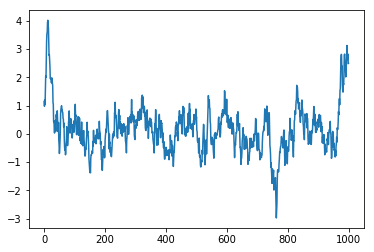

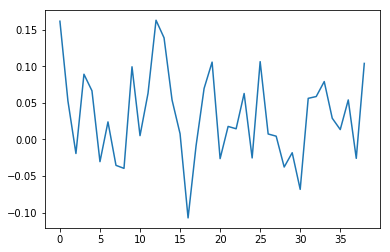

torch.Size([1775, 4])
Train Accuracy: 25 %


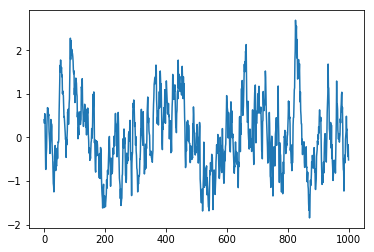

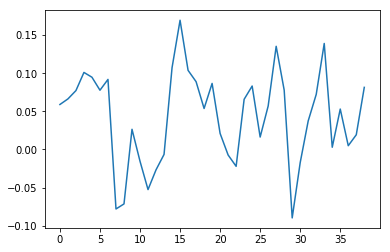

predicted set [0 1 2]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [2/20], Iter [1/17] Loss: [----- 4.9386 = 1.4684 + 100.00 * 0.0198 + 0.05 * 29.7250 -----]
Epoch [2/20], Iter [2/17] Loss: [----- 2.9816 = 1.4244 + 100.00 * 0.0007 + 0.05 * 29.7236 -----]
Epoch [2/20], Iter [3/17] Loss: [----- 3.4697 = 1.4180 + 100.00 * 0.0057 + 0.05 * 29.7223 -----]
Epoch [2/20], Iter [4/17] Loss: [----- 3.2557 = 1.4511 + 100.00 * 0.0032 + 0.05 * 29.7210 -----]
Epoch [2/20], Iter [5/17] Loss: [----- 3.4672 = 1.4879 + 100.00 * 0.0049 + 0.05 * 29.7197 -----]
Epoch [2/20], Iter [6/17] Loss: [----- 3.2027 = 1.4845 + 100.00 * 0.0023 + 0.05 * 29.7185 -----]
Epoch [2/20], Iter [7/17] Loss: [----- 3.0193 = 1.4170 + 100.00 * 0.0012 + 0.05 * 29.7173 -----]
Epoch [2/20], Iter [8/17] Loss: [----- 3.6959 = 1.4436 + 100.00 * 0.0077 + 0.05 * 29.7162 -----]
Epoch [2/20], Iter [9/17] Loss: [----- 2.9328 = 1.4375 + 100.00 * 0.0001 + 0.05 * 29.7150 -----]
Epoch [2/20], Iter [10/17] Loss: [----- 3.1964 = 1.4500 + 1

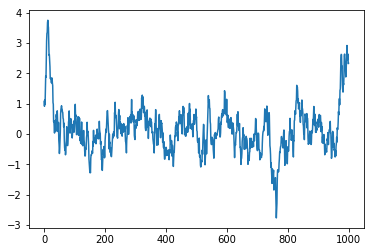

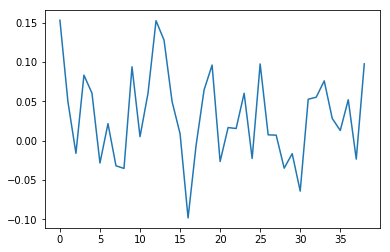

torch.Size([1775, 4])
Train Accuracy: 25 %


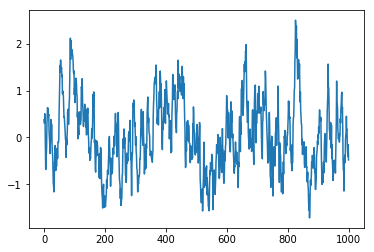

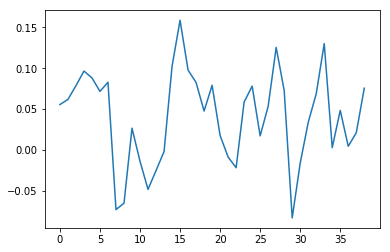

predicted set [0 1 2]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [3/20], Iter [1/17] Loss: [----- 3.1361 = 1.4550 + 100.00 * 0.0020 + 0.05 * 29.6993 -----]
Epoch [3/20], Iter [2/17] Loss: [----- 3.1388 = 1.4385 + 100.00 * 0.0022 + 0.05 * 29.6973 -----]
Epoch [3/20], Iter [3/17] Loss: [----- 2.8862 = 1.3821 + 100.00 * 0.0002 + 0.05 * 29.6954 -----]
Epoch [3/20], Iter [4/17] Loss: [----- 2.9216 = 1.4296 + 100.00 * 0.0001 + 0.05 * 29.6935 -----]
Epoch [3/20], Iter [5/17] Loss: [----- 2.8556 = 1.3659 + 100.00 * 0.0001 + 0.05 * 29.6914 -----]
Epoch [3/20], Iter [6/17] Loss: [----- 3.5636 = 1.3896 + 100.00 * 0.0069 + 0.05 * 29.6891 -----]
Epoch [3/20], Iter [7/17] Loss: [----- 4.9283 = 1.4805 + 100.00 * 0.0196 + 0.05 * 29.6869 -----]
Epoch [3/20], Iter [8/17] Loss: [----- 2.9211 = 1.4239 + 100.00 * 0.0001 + 0.05 * 29.6849 -----]
Epoch [3/20], Iter [9/17] Loss: [----- 3.1618 = 1.4841 + 100.00 * 0.0019 + 0.05 * 29.6829 -----]
Epoch [3/20], Iter [10/17] Loss: [----- 2.9006 = 1.4084 + 1

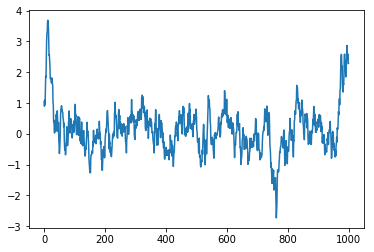

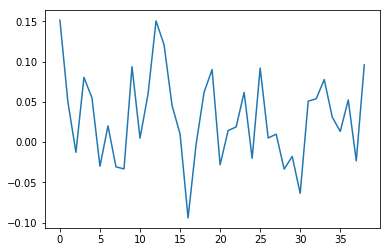

torch.Size([1775, 4])
Train Accuracy: 24 %


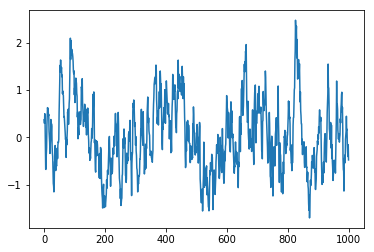

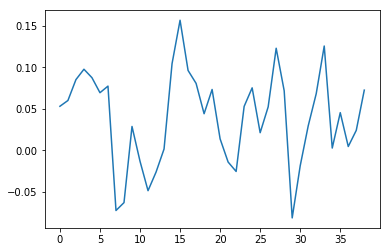

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 23 %
Epoch [4/20], Iter [1/17] Loss: [----- 3.1968 = 1.3957 + 100.00 * 0.0032 + 0.05 * 29.6654 -----]
Epoch [4/20], Iter [2/17] Loss: [----- 3.3761 = 1.4628 + 100.00 * 0.0043 + 0.05 * 29.6641 -----]
Epoch [4/20], Iter [3/17] Loss: [----- 3.2480 = 1.4453 + 100.00 * 0.0032 + 0.05 * 29.6628 -----]
Epoch [4/20], Iter [4/17] Loss: [----- 2.9228 = 1.4245 + 100.00 * 0.0002 + 0.05 * 29.6616 -----]
Epoch [4/20], Iter [5/17] Loss: [----- 3.9188 = 1.4336 + 100.00 * 0.0100 + 0.05 * 29.6603 -----]
Epoch [4/20], Iter [6/17] Loss: [----- 2.9869 = 1.4560 + 100.00 * 0.0005 + 0.05 * 29.6591 -----]
Epoch [4/20], Iter [7/17] Loss: [----- 2.8962 = 1.3939 + 100.00 * 0.0002 + 0.05 * 29.6578 -----]
Epoch [4/20], Iter [8/17] Loss: [----- 2.9849 = 1.4537 + 100.00 * 0.0005 + 0.05 * 29.6565 -----]
Epoch [4/20], Iter [9/17] Loss: [----- 3.8860 = 1.4366 + 100.00 * 0.0097 + 0.05 * 29.6551 -----]
Epoch [4/20], Iter [10/17] Loss: [----- 2.9693 = 1.4172 +

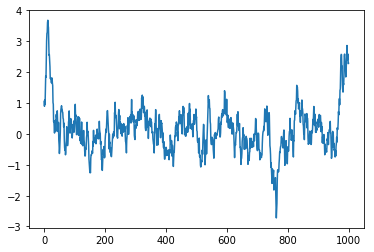

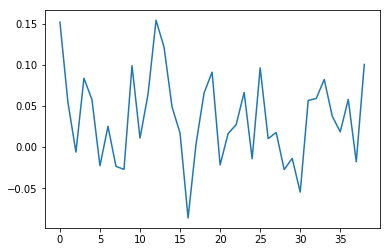

torch.Size([1775, 4])
Train Accuracy: 25 %


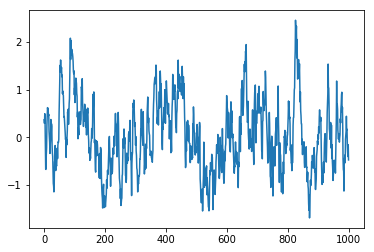

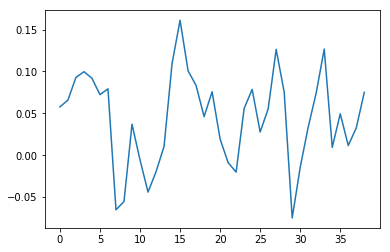

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [5/20], Iter [1/17] Loss: [----- 3.7413 = 1.3912 + 100.00 * 0.0087 + 0.05 * 29.6431 -----]
Epoch [5/20], Iter [2/17] Loss: [----- 4.7431 = 1.4300 + 100.00 * 0.0183 + 0.05 * 29.6423 -----]
Epoch [5/20], Iter [3/17] Loss: [----- 3.3962 = 1.4064 + 100.00 * 0.0051 + 0.05 * 29.6414 -----]
Epoch [5/20], Iter [4/17] Loss: [----- 2.9350 = 1.4226 + 100.00 * 0.0003 + 0.05 * 29.6406 -----]
Epoch [5/20], Iter [5/17] Loss: [----- 5.5620 = 1.3929 + 100.00 * 0.0269 + 0.05 * 29.6391 -----]
Epoch [5/20], Iter [6/17] Loss: [----- 2.9520 = 1.4625 + 100.00 * 0.0001 + 0.05 * 29.6377 -----]
Epoch [5/20], Iter [7/17] Loss: [----- 3.1318 = 1.4273 + 100.00 * 0.0022 + 0.05 * 29.6358 -----]
Epoch [5/20], Iter [8/17] Loss: [----- 3.1311 = 1.4350 + 100.00 * 0.0021 + 0.05 * 29.6339 -----]
Epoch [5/20], Iter [9/17] Loss: [----- 3.0068 = 1.4637 + 100.00 * 0.0006 + 0.05 * 29.6322 -----]
Epoch [5/20], Iter [10/17] Loss: [----- 3.1189 = 1.4439 +

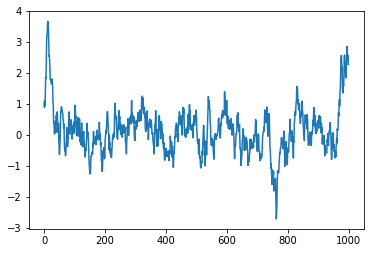

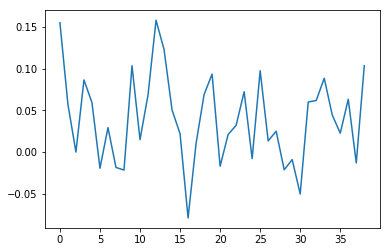

torch.Size([1775, 4])
Train Accuracy: 25 %


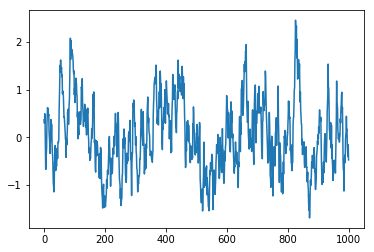

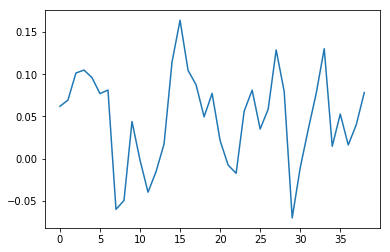

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [6/20], Iter [1/17] Loss: [----- 3.1102 = 1.4065 + 100.00 * 0.0022 + 0.05 * 29.6190 -----]
Epoch [6/20], Iter [2/17] Loss: [----- 2.9185 = 1.4264 + 100.00 * 0.0001 + 0.05 * 29.6180 -----]
Epoch [6/20], Iter [3/17] Loss: [----- 3.0343 = 1.3985 + 100.00 * 0.0015 + 0.05 * 29.6167 -----]
Epoch [6/20], Iter [4/17] Loss: [----- 3.1757 = 1.4945 + 100.00 * 0.0020 + 0.05 * 29.6156 -----]
Epoch [6/20], Iter [5/17] Loss: [----- 2.9999 = 1.4497 + 100.00 * 0.0007 + 0.05 * 29.6144 -----]
Epoch [6/20], Iter [6/17] Loss: [----- 2.9765 = 1.4257 + 100.00 * 0.0007 + 0.05 * 29.6133 -----]
Epoch [6/20], Iter [7/17] Loss: [----- 3.1417 = 1.4208 + 100.00 * 0.0024 + 0.05 * 29.6121 -----]
Epoch [6/20], Iter [8/17] Loss: [----- 2.9833 = 1.4892 + 100.00 * 0.0001 + 0.05 * 29.6110 -----]
Epoch [6/20], Iter [9/17] Loss: [----- 3.3011 = 1.4785 + 100.00 * 0.0034 + 0.05 * 29.6096 -----]
Epoch [6/20], Iter [10/17] Loss: [----- 4.1436 = 1.3627 +

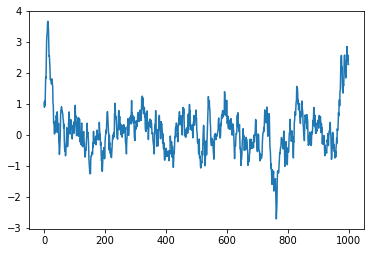

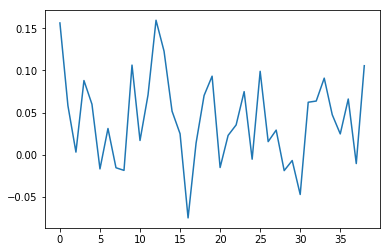

torch.Size([1775, 4])
Train Accuracy: 25 %


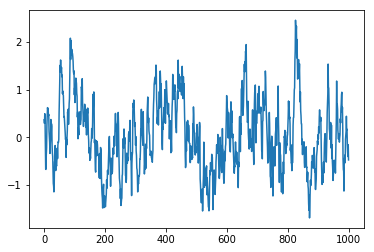

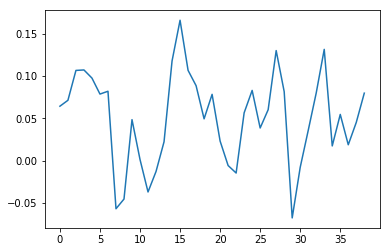

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [7/20], Iter [1/17] Loss: [----- 3.3709 = 1.3933 + 100.00 * 0.0050 + 0.05 * 29.6001 -----]
Epoch [7/20], Iter [2/17] Loss: [----- 3.0032 = 1.4520 + 100.00 * 0.0007 + 0.05 * 29.5994 -----]
Epoch [7/20], Iter [3/17] Loss: [----- 2.9867 = 1.4532 + 100.00 * 0.0005 + 0.05 * 29.5986 -----]
Epoch [7/20], Iter [4/17] Loss: [----- 3.0724 = 1.4322 + 100.00 * 0.0016 + 0.05 * 29.5978 -----]
Epoch [7/20], Iter [5/17] Loss: [----- 3.3716 = 1.4117 + 100.00 * 0.0048 + 0.05 * 29.5970 -----]
Epoch [7/20], Iter [6/17] Loss: [----- 3.2559 = 1.3950 + 100.00 * 0.0038 + 0.05 * 29.5963 -----]
Epoch [7/20], Iter [7/17] Loss: [----- 3.4476 = 1.4465 + 100.00 * 0.0052 + 0.05 * 29.5955 -----]
Epoch [7/20], Iter [8/17] Loss: [----- 2.9670 = 1.4083 + 100.00 * 0.0008 + 0.05 * 29.5948 -----]
Epoch [7/20], Iter [9/17] Loss: [----- 3.0260 = 1.4492 + 100.00 * 0.0010 + 0.05 * 29.5941 -----]
Epoch [7/20], Iter [10/17] Loss: [----- 4.3545 = 1.4033 +

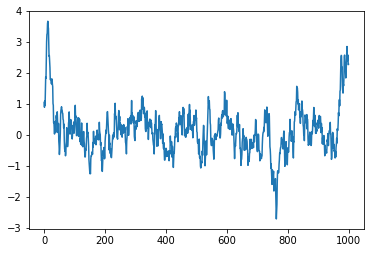

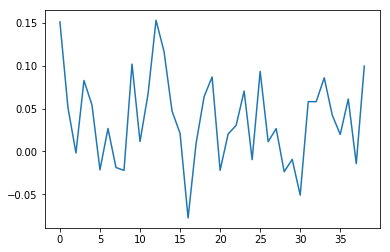

torch.Size([1775, 4])
Train Accuracy: 25 %


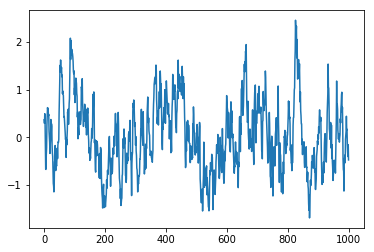

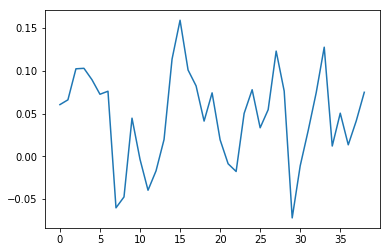

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [8/20], Iter [1/17] Loss: [----- 3.9590 = 1.4207 + 100.00 * 0.0106 + 0.05 * 29.5842 -----]
Epoch [8/20], Iter [2/17] Loss: [----- 3.1442 = 1.4954 + 100.00 * 0.0017 + 0.05 * 29.5830 -----]
Epoch [8/20], Iter [3/17] Loss: [----- 3.0113 = 1.4364 + 100.00 * 0.0010 + 0.05 * 29.5818 -----]
Epoch [8/20], Iter [4/17] Loss: [----- 3.0760 = 1.4068 + 100.00 * 0.0019 + 0.05 * 29.5806 -----]
Epoch [8/20], Iter [5/17] Loss: [----- 3.6101 = 1.4429 + 100.00 * 0.0069 + 0.05 * 29.5794 -----]
Epoch [8/20], Iter [6/17] Loss: [----- 3.7159 = 1.4373 + 100.00 * 0.0080 + 0.05 * 29.5784 -----]
Epoch [8/20], Iter [7/17] Loss: [----- 2.9686 = 1.4507 + 100.00 * 0.0004 + 0.05 * 29.5775 -----]
Epoch [8/20], Iter [8/17] Loss: [----- 3.6132 = 1.4109 + 100.00 * 0.0072 + 0.05 * 29.5765 -----]
Epoch [8/20], Iter [9/17] Loss: [----- 3.0600 = 1.4121 + 100.00 * 0.0017 + 0.05 * 29.5755 -----]
Epoch [8/20], Iter [10/17] Loss: [----- 3.4317 = 1.4517 +

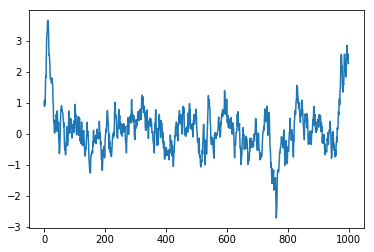

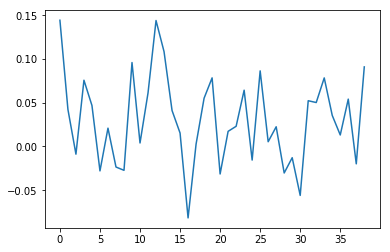

torch.Size([1775, 4])
Train Accuracy: 24 %


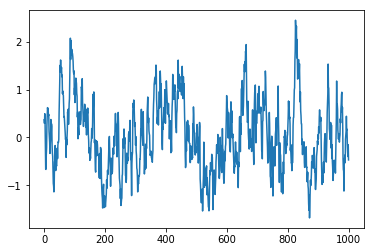

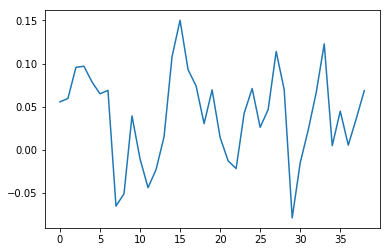

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [9/20], Iter [1/17] Loss: [----- 3.3112 = 1.3999 + 100.00 * 0.0043 + 0.05 * 29.5658 -----]
Epoch [9/20], Iter [2/17] Loss: [----- 3.0139 = 1.3721 + 100.00 * 0.0016 + 0.05 * 29.5646 -----]
Epoch [9/20], Iter [3/17] Loss: [----- 4.1318 = 1.4250 + 100.00 * 0.0123 + 0.05 * 29.5634 -----]
Epoch [9/20], Iter [4/17] Loss: [----- 2.8868 = 1.3789 + 100.00 * 0.0003 + 0.05 * 29.5623 -----]
Epoch [9/20], Iter [5/17] Loss: [----- 2.9260 = 1.4290 + 100.00 * 0.0002 + 0.05 * 29.5611 -----]
Epoch [9/20], Iter [6/17] Loss: [----- 2.8831 = 1.4004 + 100.00 * 0.0000 + 0.05 * 29.5596 -----]
Epoch [9/20], Iter [7/17] Loss: [----- 4.4086 = 1.4007 + 100.00 * 0.0153 + 0.05 * 29.5578 -----]
Epoch [9/20], Iter [8/17] Loss: [----- 2.9152 = 1.4213 + 100.00 * 0.0002 + 0.05 * 29.5561 -----]
Epoch [9/20], Iter [9/17] Loss: [----- 2.8744 = 1.3708 + 100.00 * 0.0003 + 0.05 * 29.5543 -----]
Epoch [9/20], Iter [10/17] Loss: [----- 3.0217 = 1.4109 +

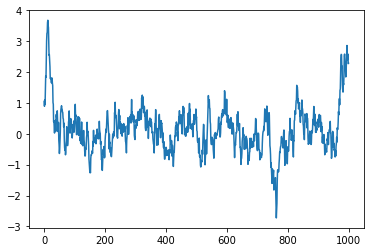

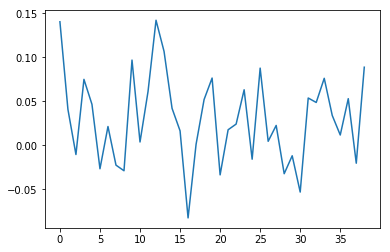

torch.Size([1775, 4])
Train Accuracy: 25 %


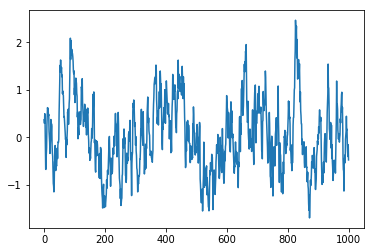

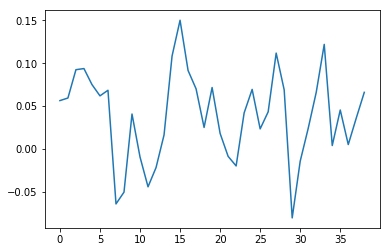

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [10/20], Iter [1/17] Loss: [----- 3.2241 = 1.3845 + 100.00 * 0.0036 + 0.05 * 29.5345 -----]
Epoch [10/20], Iter [2/17] Loss: [----- 3.2826 = 1.4506 + 100.00 * 0.0036 + 0.05 * 29.5330 -----]
Epoch [10/20], Iter [3/17] Loss: [----- 6.7916 = 1.4186 + 100.00 * 0.0390 + 0.05 * 29.5315 -----]
Epoch [10/20], Iter [4/17] Loss: [----- 2.8862 = 1.4010 + 100.00 * 0.0001 + 0.05 * 29.5302 -----]
Epoch [10/20], Iter [5/17] Loss: [----- 2.8809 = 1.3864 + 100.00 * 0.0002 + 0.05 * 29.5282 -----]
Epoch [10/20], Iter [6/17] Loss: [----- 2.9203 = 1.4371 + 100.00 * 0.0001 + 0.05 * 29.5261 -----]
Epoch [10/20], Iter [7/17] Loss: [----- 3.1033 = 1.4245 + 100.00 * 0.0020 + 0.05 * 29.5234 -----]
Epoch [10/20], Iter [8/17] Loss: [----- 2.9072 = 1.4223 + 100.00 * 0.0001 + 0.05 * 29.5209 -----]
Epoch [10/20], Iter [9/17] Loss: [----- 2.9578 = 1.3792 + 100.00 * 0.0010 + 0.05 * 29.5182 -----]
Epoch [10/20], Iter [10/17] Loss: [----- 3.8361 

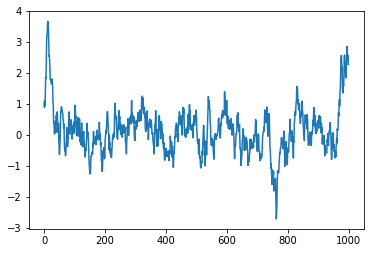

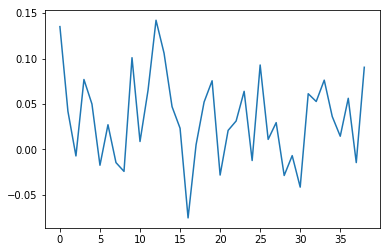

torch.Size([1775, 4])
Train Accuracy: 25 %


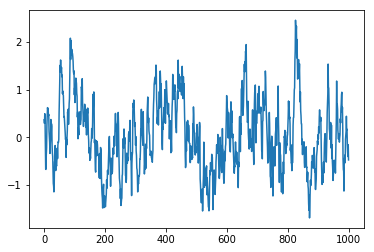

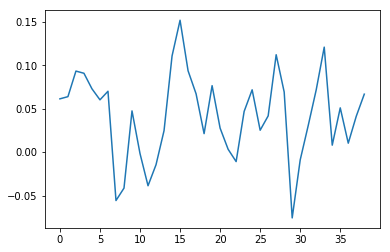

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [11/20], Iter [1/17] Loss: [----- 4.0712 = 1.4399 + 100.00 * 0.0116 + 0.05 * 29.4984 -----]
Epoch [11/20], Iter [2/17] Loss: [----- 2.9066 = 1.4253 + 100.00 * 0.0001 + 0.05 * 29.4969 -----]
Epoch [11/20], Iter [3/17] Loss: [----- 3.0307 = 1.4075 + 100.00 * 0.0015 + 0.05 * 29.4948 -----]
Epoch [11/20], Iter [4/17] Loss: [----- 2.9044 = 1.4077 + 100.00 * 0.0002 + 0.05 * 29.4928 -----]
Epoch [11/20], Iter [5/17] Loss: [----- 2.9012 = 1.3785 + 100.00 * 0.0005 + 0.05 * 29.4907 -----]
Epoch [11/20], Iter [6/17] Loss: [----- 3.5398 = 1.4278 + 100.00 * 0.0064 + 0.05 * 29.4887 -----]
Epoch [11/20], Iter [7/17] Loss: [----- 2.9955 = 1.3799 + 100.00 * 0.0014 + 0.05 * 29.4868 -----]
Epoch [11/20], Iter [8/17] Loss: [----- 3.9282 = 1.4001 + 100.00 * 0.0105 + 0.05 * 29.4850 -----]
Epoch [11/20], Iter [9/17] Loss: [----- 3.0195 = 1.4000 + 100.00 * 0.0015 + 0.05 * 29.4833 -----]
Epoch [11/20], Iter [10/17] Loss: [----- 3.9891 

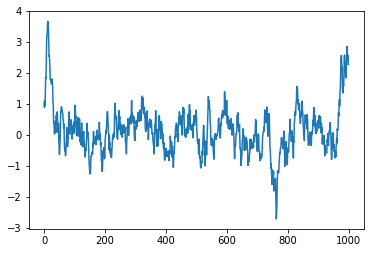

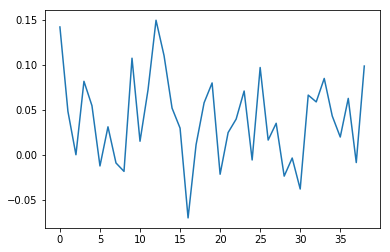

torch.Size([1775, 4])
Train Accuracy: 26 %


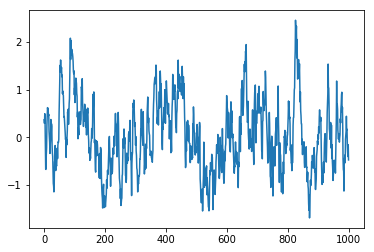

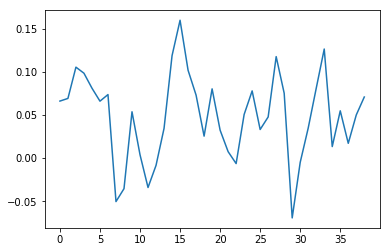

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [12/20], Iter [1/17] Loss: [----- 4.1442 = 1.4124 + 100.00 * 0.0126 + 0.05 * 29.4708 -----]
Epoch [12/20], Iter [2/17] Loss: [----- 2.8715 = 1.3940 + 100.00 * 0.0000 + 0.05 * 29.4698 -----]
Epoch [12/20], Iter [3/17] Loss: [----- 4.1190 = 1.3667 + 100.00 * 0.0128 + 0.05 * 29.4681 -----]
Epoch [12/20], Iter [4/17] Loss: [----- 3.2398 = 1.3850 + 100.00 * 0.0038 + 0.05 * 29.4665 -----]
Epoch [12/20], Iter [5/17] Loss: [----- 2.9938 = 1.3637 + 100.00 * 0.0016 + 0.05 * 29.4651 -----]
Epoch [12/20], Iter [6/17] Loss: [----- 2.8754 = 1.3942 + 100.00 * 0.0001 + 0.05 * 29.4637 -----]
Epoch [12/20], Iter [7/17] Loss: [----- 3.0744 = 1.4481 + 100.00 * 0.0015 + 0.05 * 29.4620 -----]
Epoch [12/20], Iter [8/17] Loss: [----- 2.8968 = 1.4174 + 100.00 * 0.0001 + 0.05 * 29.4603 -----]
Epoch [12/20], Iter [9/17] Loss: [----- 3.5297 = 1.3807 + 100.00 * 0.0068 + 0.05 * 29.4584 -----]
Epoch [12/20], Iter [10/17] Loss: [----- 2.9065 

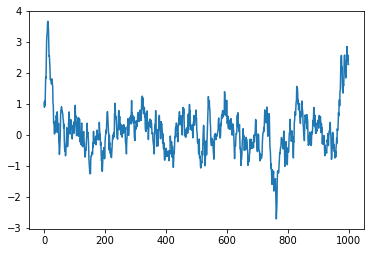

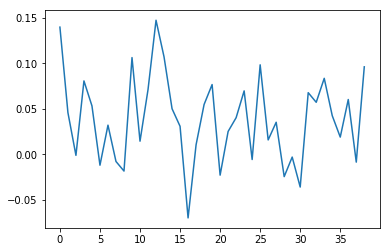

torch.Size([1775, 4])
Train Accuracy: 26 %


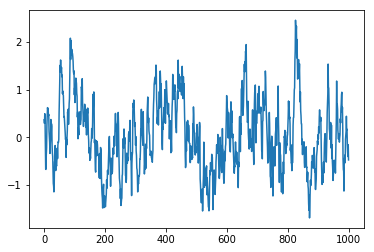

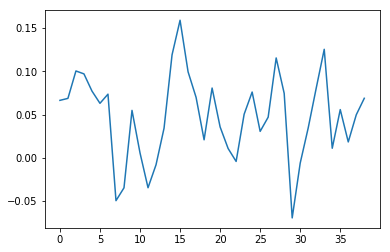

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [13/20], Iter [1/17] Loss: [----- 2.9817 = 1.3928 + 100.00 * 0.0012 + 0.05 * 29.4390 -----]
Epoch [13/20], Iter [2/17] Loss: [----- 2.8798 = 1.3943 + 100.00 * 0.0001 + 0.05 * 29.4371 -----]
Epoch [13/20], Iter [3/17] Loss: [----- 2.9150 = 1.4158 + 100.00 * 0.0003 + 0.05 * 29.4351 -----]
Epoch [13/20], Iter [4/17] Loss: [----- 2.9126 = 1.4286 + 100.00 * 0.0001 + 0.05 * 29.4331 -----]
Epoch [13/20], Iter [5/17] Loss: [----- 3.4169 = 1.4042 + 100.00 * 0.0054 + 0.05 * 29.4310 -----]
Epoch [13/20], Iter [6/17] Loss: [----- 2.9380 = 1.4118 + 100.00 * 0.0005 + 0.05 * 29.4290 -----]
Epoch [13/20], Iter [7/17] Loss: [----- 2.8983 = 1.3859 + 100.00 * 0.0004 + 0.05 * 29.4271 -----]
Epoch [13/20], Iter [8/17] Loss: [----- 2.9125 = 1.4383 + 100.00 * 0.0000 + 0.05 * 29.4253 -----]
Epoch [13/20], Iter [9/17] Loss: [----- 2.9579 = 1.4078 + 100.00 * 0.0008 + 0.05 * 29.4229 -----]
Epoch [13/20], Iter [10/17] Loss: [----- 2.8616 

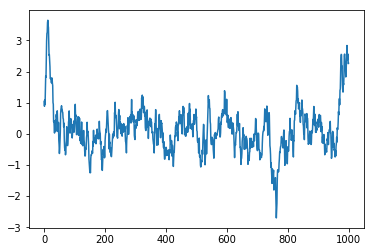

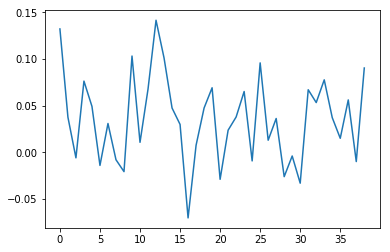

torch.Size([1775, 4])
Train Accuracy: 25 %


KeyboardInterrupt: 

In [69]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 + reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

In [ ]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)